In [76]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from collections import Counter
import re
import string
import pickle
import json
import numpy as np


In [77]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/akeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/akeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/akeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [78]:
# === LOAD DATA ===
with open("../dataset/dataset_ner_srl.json", "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = [[token.lower() for token in item["tokens"]] for item in data]
ner_labels = [item["labels_ner"] for item in data]
srl_labels = [item["labels_srl"] for item in data]

print(len(sentences), "sentences")

# === COUNTERS ===
ner_counter = Counter()
srl_counter = Counter()

for ner_seq in ner_labels:
    ner_counter.update(ner_seq)

for srl_seq in srl_labels:
    srl_counter.update(srl_seq)

# === PRINT RESULT ===
print("=== NER LABEL COUNTS ===")
for label, count in ner_counter.items():
    print(f"{label} -> {count} labels")

print("\n=== SRL LABEL COUNTS ===")
for label, count in srl_counter.items():
    print(f"{label} -> {count} labels")

28 sentences
=== NER LABEL COUNTS ===
O -> 338 labels
B-LOC -> 17 labels
V -> 2 labels
B-MISC -> 1 labels
B-TIME -> 1 labels
I-TIME -> 2 labels
I-LOC -> 1 labels
B-QUANT -> 2 labels
I-QUANT -> 3 labels
B-DATE -> 2 labels

=== SRL LABEL COUNTS ===
ARG1 -> 116 labels
ARGM-LOC -> 13 labels
AM-NEG -> 2 labels
V -> 34 labels
ARGM-SRC -> 9 labels
O -> 69 labels
AM-QUE -> 5 labels
ARGM-BNF -> 4 labels
ARG2 -> 24 labels
ARGM-MNR -> 1 labels
ARG0 -> 16 labels
AM-TMP -> 25 labels
AM-PRP -> 1 labels
AM-MOD -> 5 labels
AM-ADV -> 1 labels
AM-CAU -> 1 labels
AM-EXT -> 6 labels
AM-MNR -> 9 labels
AM-DIS -> 2 labels
AM-FRQ -> 2 labels
ARGM-PNC -> 1 labels
R-ARG1 -> 3 labels
AM-LOC -> 14 labels
AM-DIR -> 4 labels
ARGM-CAU -> 3 labels


In [79]:
# text preprocessing
stop_words = set(stopwords.words("indonesian"))                                                                                                                                                                                                                                                                             
factory = StemmerFactory()
stemmer = factory.create_stemmer()

with open("../normalize_text/normalize.json", "r", encoding="utf-8") as file:
    normalization_dict = json.load(file)
    
def text_preprocessing(text):
    
    # if(text == "?" or text == "." or text == "!"): return text
    # lowercase
    text = text.lower()
    
    # remove punctuation
    # text = text.translate(str.maketrans("", "", string.punctuation))
    
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # tokenize
    # tokens = word_tokenize(text)
    
    # normalization
    # tokens = normalization_dict.get(text, text)  
  
    
    # stemming
    # tokens = stemmer.stem(tokens)
    
    
    # remove stopwords
    # tokens = [word for word in tokens if word not in stop_words]
    
    # print(f"Original: {text}")
    # print(f"Normalized: {tokens}")
    
    return text

# sentences = [text_preprocessing(" ".join(sentence)) for sentence in sentences]
print("old", sentences)
preprocessing_sentences = []

for text in sentences:
    result = []
    for i in range(len(text)):
        text[i] = text_preprocessing(text[i])
        result.append(text[i])
    preprocessing_sentences.append(result)

print("new", preprocessing_sentences, "\n", len(preprocessing_sentences))

    

old [['keberagaman', 'potensi', 'sumber', 'daya', 'alam', 'indonesia', 'tidak', 'lepas', 'dari', 'proses', 'geografis', 'yang', 'terjadi', '.'], ['bagaimana', 'proses', 'geografis', 'di', 'indonesia', '?'], ['bagaimana', 'pengaruh', 'proses', 'geografis', 'bagi', 'keragaman', 'alam', 'dan', 'keragaman', 'sosial', 'masyarakat', 'indonesia', '?'], ['bagaimana', 'mengoptimalkan', 'peranan', 'sumber', 'daya', 'manusia', 'dalam', 'mengelola', 'sumber', 'daya', 'alam', 'indonesia', '?'], ['apakah', 'sumber', 'daya', 'manusia', 'di', 'indonesia', 'sudah', 'memenuhi', 'syarat', 'untuk', 'mengolah', 'pariwisata', 'yang', 'dimilikinya', '?'], ['bagaimana', 'lembaga', 'sosial', 'yang', 'akan', 'mewadahi', 'untuk', 'mengolah', 'sumber', 'daya', 'alam', 'dan', 'sumber', 'daya', 'manusianya', '?'], ['kalian', 'juga', 'perlu', 'memahami', ',', 'bahwa', 'keragaman', 'sosial', 'dan', 'budaya', 'telah', 'menarik', 'kedatangan', 'bangsa-bangsa', 'asing', 'sejak', 'ribuan', 'tahun', 'yang', 'lalu', '.'], 

In [80]:
words = list(set(word for sentence in preprocessing_sentences for word in sentence))
word2idx = {word: idx + 2 for idx, word in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

all_ner_tags = sorted(set(tag for seq in ner_labels for tag in seq))
all_srl_tags = sorted(set(tag for seq in srl_labels for tag in seq))
tag2idx_ner = {tag: idx for idx, tag in enumerate(all_ner_tags)}
tag2idx_srl = {tag: idx for idx, tag in enumerate(all_srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

print(words)
print(word2idx)
print(all_ner_tags)
print(all_srl_tags)
print(tag2idx_ner)
print(tag2idx_srl)
print(idx2tag_ner)
print(idx2tag_srl)

['mengelola', 'memengaruhi', 'mata', 'yaitu', 'april-september', 'kehidupan', 'matahari', ')', '.', 'pencaharian', 'cuaca', 'bagaimana', 'bangsa-bangsa', 'selain', 'kalian', 'singkat', 'tropis', 'dapat', '(', 'kebiasaan', 'barat', 'lembaga', 'lain', 'masyarakat', 'letak', 'waktu', 'sehari-hari', 'dimiliki', 'dengan', 'hobi', 'ke', 'sumber', 'hal', 'karena', 'mengoptimalkan', 'relatif', 'prakiraan', 'bahan', 'sedikit', 'kedatangan', 'dan', 'musim', 'kondisi', 'kesenangan', 'bagi', 'peranan', 'semakin', 'makanan', 'manusianya', 'akan', 'tentang', 'juga', 'sosial', 'asia', 'pada', 'terluas', 'wilayah', 'negara', 'sedangkan', 'lautan', 'oktober-maret', 'pengaruh', 'awal', '1.910.932,37', 'bersyukur', 'iklim', 'tersebut', 'merupakan', 'rata-rata', 'timur', 'kelembaban', 'angin', 'memperhatikan', 'curah', 'berikut', 'jatuh', 'perkembangan', 'suhu', 'tidak', 'patut', '5,8', ',', 'abad', 'daya', 'merancang', 'juta', 'udara', 'adalah', 'penting', 'dalam', 'bagian', 'syarat', 'mencapai', 'ini', 

In [81]:

# === ENCODING ===
X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in ts] for ts in ner_labels]
y_srl = [[tag2idx_srl[t] for t in ts] for ts in srl_labels]

maxlen = max(len(x) for x in X)
X = pad_sequences(X, maxlen=maxlen, padding="post", value=word2idx["PAD"])
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=tag2idx_ner["O"])
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=tag2idx_srl["O"])
y_ner_cat = [to_categorical(seq, num_classes=len(tag2idx_ner)) for seq in y_ner]
y_srl_cat = [to_categorical(seq, num_classes=len(tag2idx_srl)) for seq in y_srl]

print(X)
print("y_ner \n ")
print(y_ner)
print("y_srl \n ")
print(y_srl)
print("y_ner cat \n ")
print(y_ner_cat)
print("y_srl cat \n ")
print(y_srl_cat)


[[132 139  33  85 164  96  80 142 163 124 174 143 166  10   0   0   0   0
    0   0   0   0]
 [ 13 124 174 112  96 113   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 13  63 124 174  46 100 164  42 100  54  25  96 113   0   0   0   0   0
    0   0   0   0]
 [ 13  36  47  33  85 158  91   2  33  85 164  96 113   0   0   0   0   0
    0   0   0   0]
 [140  33  85 158 112  96 138 106  93 175 155 110 143 146 113   0   0   0
    0   0   0   0]
 [ 13  23  54 143  51 169 175 155  33  85 164  42  33  85  50 113   0   0
    0   0   0   0]
 [ 16  53 157 117  83 104 100  54  42 130 120 141  41  14 115 152 165 172
  143 121  10   0]
 [ 78 129 112  96  80 142 163  78 176  42 161  56  64  84 159  10   0   0
    0   0   0   0]
 [127  96  81  66  35 124 174  42 100 164 143  29  10   0   0   0   0   0
    0   0   0   0]
 [ 96  69  59  57 112  55 118  10   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [160 134  96 148  65 171  10   0   0   0   0   0   0   0   0   0   0 

In [82]:
# split dataset 
X_temp, X_test, y_ner_temp, y_ner_test, y_srl_temp, y_srl_test = train_test_split(
    X, y_ner_cat, y_srl_cat, test_size=0.1, random_state=42
)
X_train, X_val, y_ner_train, y_ner_val, y_srl_train, y_srl_val = train_test_split(
    X_temp, y_ner_temp, y_srl_temp, test_size=0.1111, random_state=42  # ~10% of total
)

In [83]:
#training model
input_layer = Input(shape=(maxlen,))
embedding = Embedding(input_dim=len(word2idx), output_dim=64)(input_layer)
bilstm = Bidirectional(LSTM(units=64, return_sequences=True))(embedding)
out_ner = TimeDistributed(Dense(len(tag2idx_ner), activation="softmax"), name="ner_output")(bilstm)
out_srl = TimeDistributed(Dense(len(tag2idx_srl), activation="softmax"), name="srl_output")(bilstm)

model = Model(inputs=input_layer, outputs=[out_ner, out_srl])
model.compile(
    optimizer="adam",
    loss={"ner_output": "categorical_crossentropy", "srl_output": "categorical_crossentropy"},
    metrics={"ner_output": "accuracy", "srl_output": "accuracy"}
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 22, 64)    │     11,392 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 22, 128)   │     66,048 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 22, 10)    │      1,290 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 22, 25)    │      3,225 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,955 (320.14 KB)

 Trainable params: 81,955 (320.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.4074 - ner_output_accuracy: 0.7423 - ner_output_loss: 2.2128 - srl_output_accuracy: 0.2337 - srl_output_loss: 3.1946 - val_loss: 4.5710 - val_ner_output_accuracy: 0.9545 - val_ner_output_loss: 1.6993 - val_srl_output_accuracy: 0.6061 - val_srl_output_loss: 2.9475
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1426 - ner_output_accuracy: 0.9434 - ner_output_loss: 1.3429 - srl_output_accuracy: 0.5027 - srl_output_loss: 2.7998 - val_loss: 1.8463 - val_ner_output_accuracy: 0.9545 - val_ner_output_loss: 0.3212 - val_srl_output_accuracy: 0.6061 - val_srl_output_loss: 1.6901
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1865 - ner_output_accuracy: 0.9540 - ner_output_loss: 0.3207 - srl_output_accuracy: 0.5062 - srl_output_loss: 1.8658 - val_loss: 1.5277 - val_ner_output_accuracy: 0.9545 - val_ner_output_loss: 0.3891 - val_srl_output_accuracy: 0.6061 - val_srl_output_loss: 1.3498
Epoch 4/10
11/11 ━━━━━━━━━━

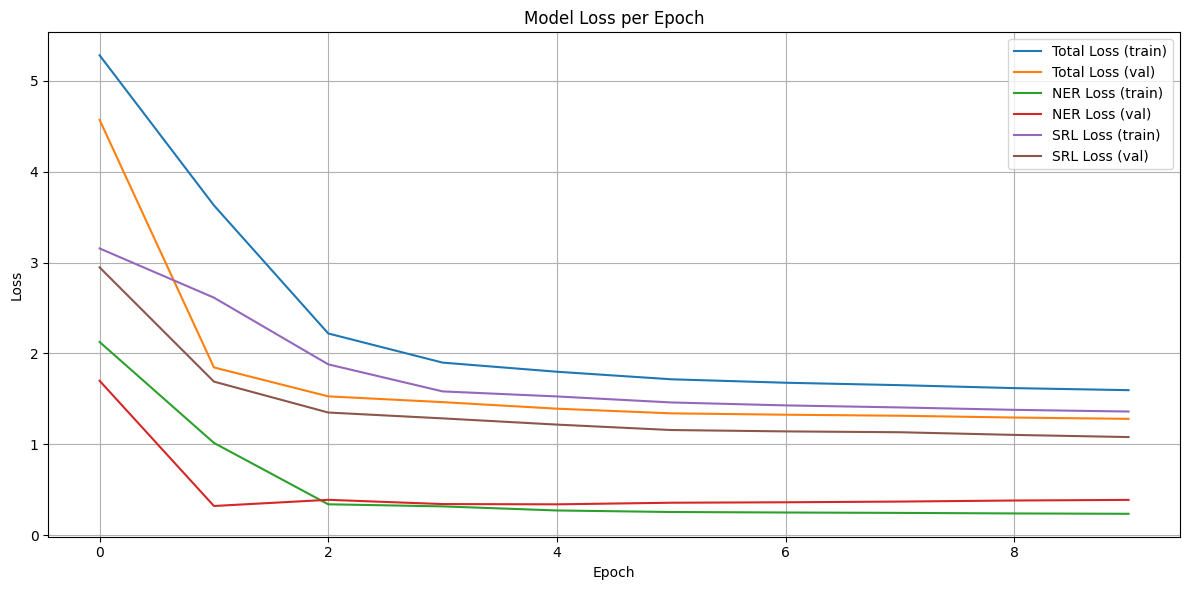

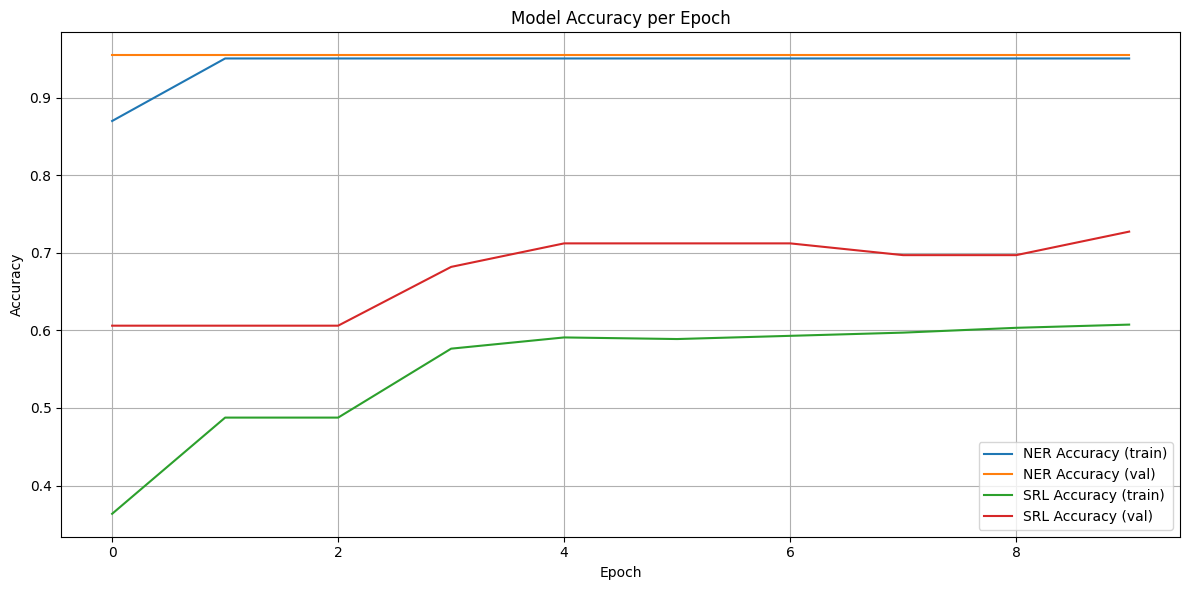

In [84]:

# === TRAINING ===
history = model.fit(
    X_train,
    {"ner_output": np.array(y_ner_train), "srl_output": np.array(y_srl_train)},
    validation_data=(X_val, {"ner_output": np.array(y_ner_val), "srl_output": np.array(y_srl_val)}),
    batch_size=2,
    epochs=10
)

# === SAVE ===
model.save("multi_task_bilstm_model.keras")
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("tag2idx_ner.pkl", "wb") as f:
    pickle.dump(tag2idx_ner, f)
with open("tag2idx_srl.pkl", "wb") as f:
    pickle.dump(tag2idx_srl, f)
    
    
history_dict = history.history

# === LOSS ===
plt.figure(figsize=(12, 6))

plt.plot(history_dict["loss"], label="Total Loss (train)")
plt.plot(history_dict["val_loss"], label="Total Loss (val)")
plt.plot(history_dict["ner_output_loss"], label="NER Loss (train)")
plt.plot(history_dict["val_ner_output_loss"], label="NER Loss (val)")
plt.plot(history_dict["srl_output_loss"], label="SRL Loss (train)")
plt.plot(history_dict["val_srl_output_loss"], label="SRL Loss (val)")

plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === ACCURACY ===
plt.figure(figsize=(12, 6))

plt.plot(history_dict["ner_output_accuracy"], label="NER Accuracy (train)")
plt.plot(history_dict["val_ner_output_accuracy"], label="NER Accuracy (val)")
plt.plot(history_dict["srl_output_accuracy"], label="SRL Accuracy (train)")
plt.plot(history_dict["val_srl_output_accuracy"], label="SRL Accuracy (val)")

plt.title("Model Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# evaluation
y_pred_ner, y_pred_srl = model.predict(X_test)

y_true_ner = [[idx2tag_ner[np.argmax(tok)] for tok in seq] for seq in y_ner_test]
y_pred_ner = [[idx2tag_ner[np.argmax(tok)] for tok in seq] for seq in y_pred_ner]

y_true_srl = [[idx2tag_srl[np.argmax(tok)] for tok in seq] for seq in y_srl_test]
y_pred_srl = [[idx2tag_srl[np.argmax(tok)] for tok in seq] for seq in y_pred_srl]

print("\n📊 [NER] Test Set Classification Report:")
print(classification_report(y_true_ner, y_pred_ner))

print("\n📊 [SRL] Test Set Classification Report:")
print(classification_report(y_true_srl, y_pred_srl))


# import numpy as np

# # Prediksi model (output = probabilitas)
# y_pred_ner = model.predict(X_test)[0]
# y_pred_ner_idx = np.argmax(y_pred_ner, axis=-1)
# y_true_ner_idx = np.argmax(y_ner_test, axis=-1)

# # Mapping ke string
# y_pred_ner_str = []
# y_true_ner_str = []

# for y_true_seq, y_pred_seq in zip(y_true_ner_idx, y_pred_ner_idx):
#     true_seq = []
#     pred_seq = []
#     for t, p in zip(y_true_seq, y_pred_seq):
#         if idx2tag_ner[t] != "PAD":
#             true_seq.append(idx2tag_ner[t])
#             pred_seq.append(idx2tag_ner[p])
#     y_true_ner_str.append(true_seq)
#     y_pred_ner_str.append(pred_seq)

# from seqeval.metrics import classification_report
# print("\n📊 [NER] Test Set Classification Report:")
# print(classification_report(y_true_ner_str, y_pred_ner_str))


# from collections import Counter

# flat_preds = [tag for seq in y_pred_ner_str for tag in seq]
# print(Counter(flat_preds))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step

📊 [NER] Test Set Classification Report:
              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         3
   macro avg       0.00      0.00      0.00         3
weighted avg       0.00      0.00      0.00         3


📊 [SRL] Test Set Classification Report:
              precision    recall  f1-score   support

         CAU       0.00      0.00      0.00         1
         LOC       0.00      0.00      0.00         1
         MOD       0.00      0.00      0.00         1
         RG0       0.00      0.00      0.00         1
         RG1       0.00      0.00      0.00        10
         RG2       0.00      0.00      0.00         1
           _       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00        17
   macro avg       0.00      0.00      0.00        17
weighted avg       0.00      0.00      0.00        17



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/

In [86]:

def plot_confusion_matrix(y_true_flat, y_pred_flat, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

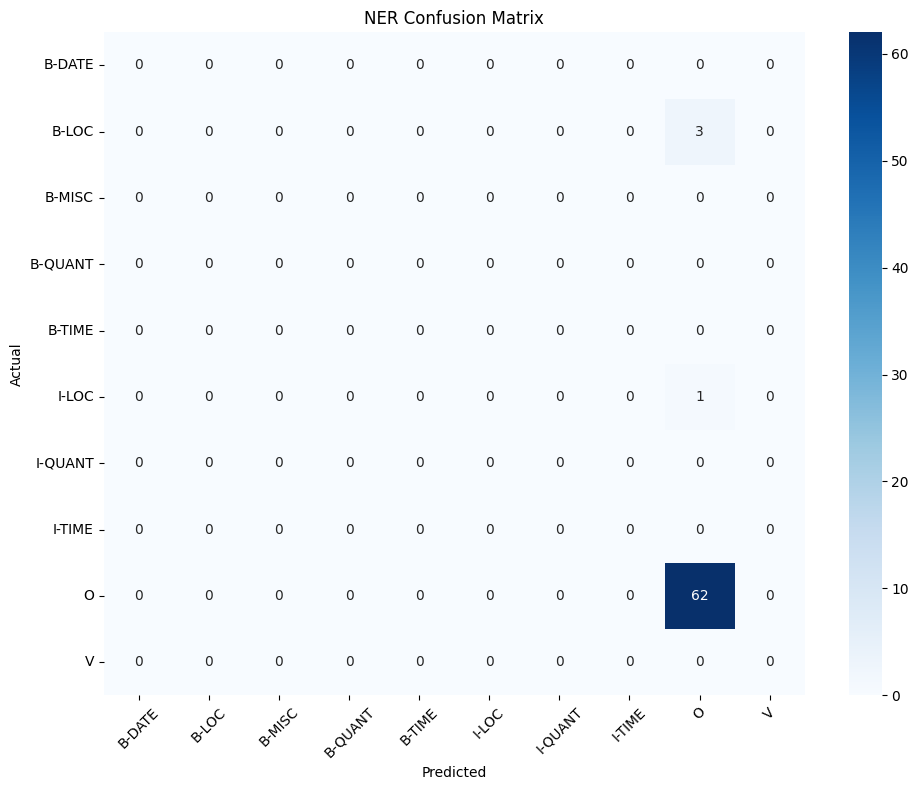

In [87]:

# Flatten label
y_true_flat_ner = [tag for seq in y_true_ner for tag in seq]
y_pred_flat_ner = [tag for seq in y_pred_ner for tag in seq]

# Buat plot
plot_confusion_matrix(
    y_true_flat_ner, 
    y_pred_flat_ner, 
    labels=list(tag2idx_ner.keys()), 
    title="NER Confusion Matrix"
)


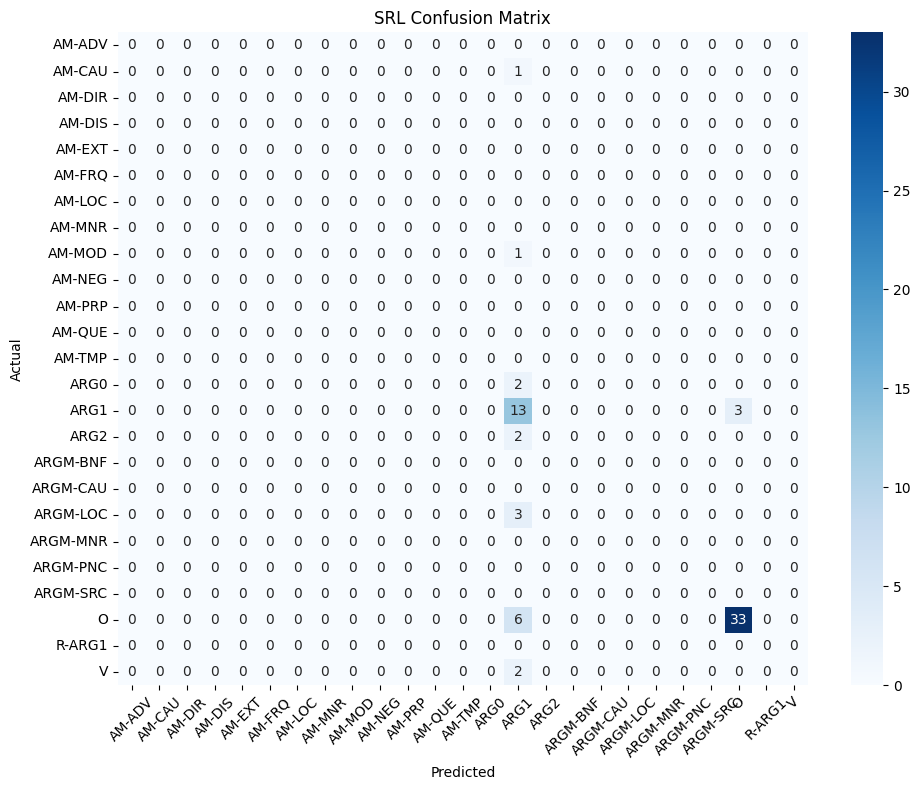

In [88]:
y_true_flat_srl = [tag for seq in y_true_srl for tag in seq]
y_pred_flat_srl = [tag for seq in y_pred_srl for tag in seq]

plot_confusion_matrix(
    y_true_flat_srl, 
    y_pred_flat_srl, 
    labels=list(tag2idx_srl.keys()), 
    title="SRL Confusion Matrix"
)
